# Face Recognition Using CNN

## Tentang dataset

> Data tersebut berisi gambar wajah yang telah dipotong dari 18 orang yang dibagi ke dalam Pelatihan dan pengujian. Model akan dilatih menggunakan CNN menggunakan gambar-gambar di folder Pelatihan dan kemudian menguji model dengan menggunakan gambar-gambar yang tidak terlihat dari folder pengujian, untuk memeriksa apakah model tersebut dapat mengenali nomor wajah, yaitu label yang diberikan kepada setiap wajah selama pelatihan)

In [23]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import time
import os

import tensorflow
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import Callback, EarlyStopping

In [2]:
train_dir = r"Face Images/Face Images/Final Training Images"
test_dir = r"Face Images/Face Images/Final Testing Images"

## Explorasi data

### Mengecek jumlah data

In [11]:
# Fungsi untuk menghitung jumlah gambar per kelas
def count_images_per_class(directory):
    data_info = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            num_images = len([f for f in os.listdir(label_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
            data_info.append((label, num_images))
    return data_info

   Pegawai  Jumlah Foto
0    face1           20
1   face10           17
2   face11           16
3   face12           15
4   face13           15
5   face14           16
6   face15           14
7   face16           14
8   face17           16
9   face18           14
10   face2           16
11   face3           14
12   face4           15
13   face5           17
14   face6           15
15   face7           13
16   face8           12
17   face9           14


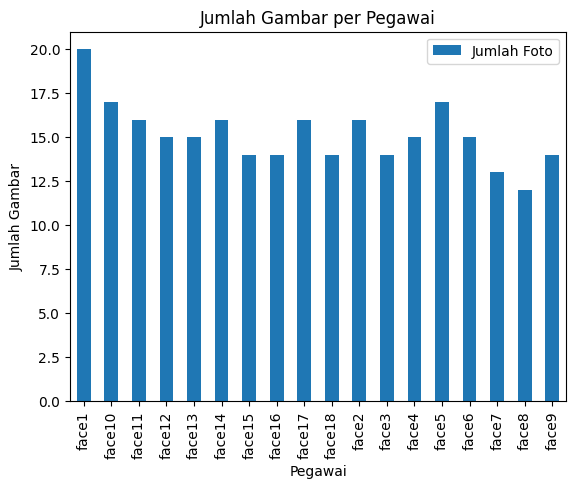

In [12]:
# Hitung jumlah gambar per kelas
data_info = count_images_per_class(train_dir)
df = pd.DataFrame(data_info, columns=['Pegawai', 'Jumlah Foto'])

# Tampilkan informasi jumlah gambar per kelas
print(df)

# Visualisasikan jumlah gambar per kelas
df.set_index('Pegawai').plot(kind='bar')
plt.xlabel('Pegawai')
plt.ylabel('Jumlah Gambar')
plt.title('Jumlah Gambar per Pegawai')
plt.show()

### Mengecek sample data tiap class

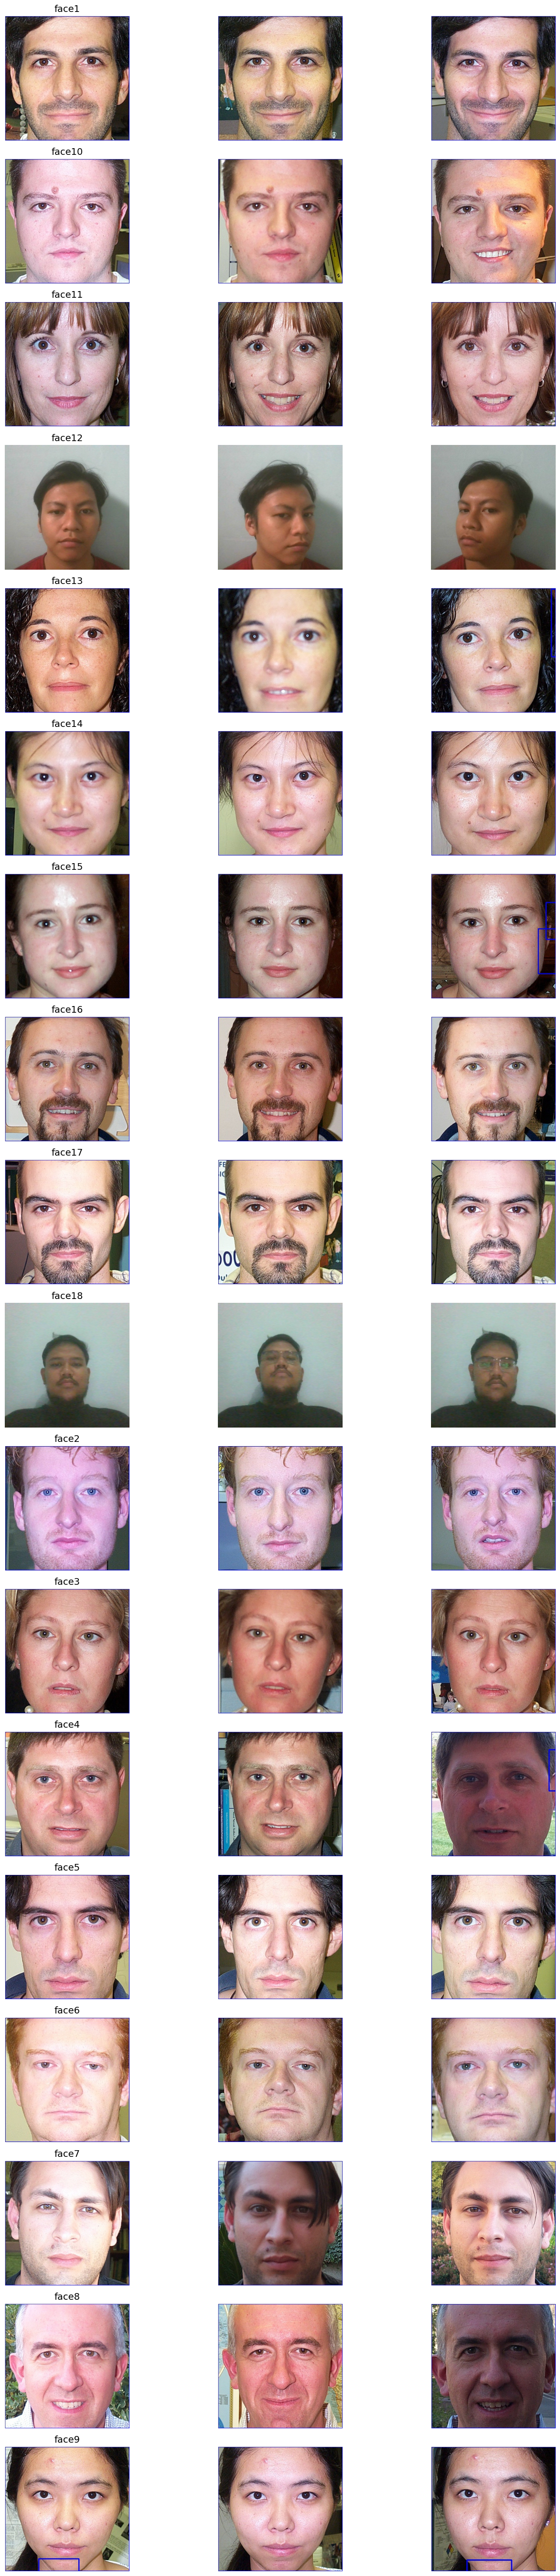

In [13]:
def show_images_from_folder(folder_path, num_images=3):
    """
    Menampilkan sejumlah gambar dari setiap subfolder di dalam folder_path.
    
    Parameters:
    - folder_path: Path ke folder utama yang berisi subfolder untuk setiap kelas.
    - num_images: Jumlah gambar yang akan ditampilkan dari setiap subfolder.
    """
    # Dapatkan daftar subfolder
    subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]
    
    # Tentukan jumlah baris dan kolom untuk subplot
    num_classes = len(subfolders)
    num_cols = num_images
    num_rows = num_classes

    # Buat figure untuk plot
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
    axes = axes.flatten() if num_classes > 1 else [axes]

    for idx, subfolder in enumerate(subfolders):
        # Dapatkan nama kelas (subfolder)
        class_name = os.path.basename(subfolder)
        
        # Dapatkan daftar gambar dalam subfolder
        image_files = [os.path.join(subfolder, f) for f in os.listdir(subfolder) if f.endswith(('.png', '.jpg', '.jpeg'))]

        for jdx, image_file in enumerate(image_files[:num_images]):
            # Baca gambar menggunakan OpenCV
            image = cv2.imread(image_file)
            # Konversi dari BGR (OpenCV default) ke RGB (matplotlib default)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Tentukan indeks untuk subplot
            ax_idx = idx * num_cols + jdx
            
            # Tampilkan gambar di subplot
            axes[ax_idx].imshow(image)
            axes[ax_idx].axis('off')
            if jdx == 0:
                axes[ax_idx].set_title(class_name, fontsize=14)

    plt.tight_layout()
    plt.show()
# Tampilkan beberapa gambar dari setiap kelas di folder train
show_images_from_folder(train_dir, num_images=3)

### Memeriksa ukuran gambar

In [14]:
# Fungsi untuk memeriksa ukuran gambar
def get_image_sizes(directory):
    image_sizes = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for image_name in os.listdir(label_dir):
                if image_name.endswith(('.png', '.jpg', '.jpeg')):
                    image_path = os.path.join(label_dir, image_name)
                    image = cv2.imread(image_path)
                    if image is not None:
                        image_sizes.append(image.shape[:2])
    return image_sizes

In [18]:
# Periksa ukuran gambar
image_sizes = get_image_sizes(train_dir)
size_df = pd.DataFrame(image_sizes, columns=['Height', 'Width'])
size_df

Height  Width
0       304    304
1       321    321
2       335    335
3       331    331
4       329    329
..      ...    ...
268     311    311
269     307    307
270     316    316
271     296    296
272     308    308

[273 rows x 2 columns]

In [19]:
# Tampilkan informasi ukuran gambar
print(size_df.describe())

           Height       Width
count  273.000000  273.000000
mean   360.692308  360.692308
std    125.774456  125.774456
min    249.000000  249.000000
25%    306.000000  306.000000
50%    320.000000  320.000000
75%    338.000000  338.000000
max    720.000000  720.000000


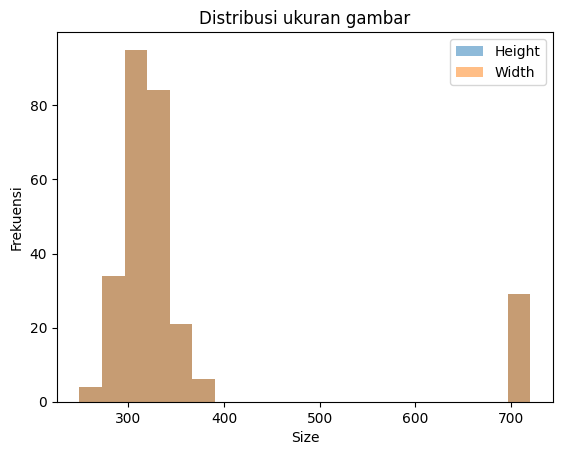

In [16]:
# Visualisasikan distribusi ukuran gambar
size_df.plot(kind='hist', alpha=0.5, bins=20)
plt.xlabel('Size')
plt.ylabel('Frekuensi')
plt.title('Distribusi ukuran gambar')
plt.show()

### Memeriksa distribusi pixel

In [24]:
# Fungsi untuk menghitung distribusi piksel
def calculate_pixel_distribution(image):
    chans = cv2.split(image)
    features = []
    for chan in chans:
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        hist = hist / hist.sum()
        features.append(hist)
    return features

In [25]:
# Hitung distribusi piksel untuk semua gambar
pixel_distributions = []
for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir, label)
    if os.path.isdir(label_dir):
        for image_name in os.listdir(label_dir):
            if image_name.endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(label_dir, image_name)
                image = cv2.imread(image_path)
                if image is not None:
                    distribution = calculate_pixel_distribution(image)
                    pixel_distributions.append((label, *distribution))

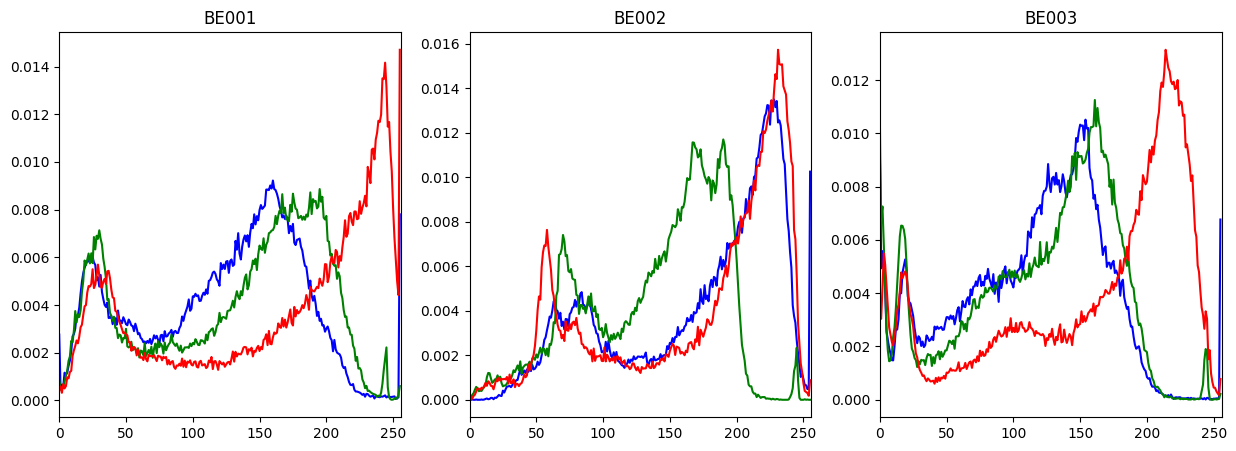

In [160]:
# Buat DataFrame untuk distribusi piksel
pixel_df = pd.DataFrame(pixel_distributions)

# Visualisasikan distribusi piksel untuk beberapa gambar (contoh)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, label in enumerate(df['Pegawai'].unique()[:3]): #Menggunakan 3 gambar saja
    example_image = os.path.join(train_dir, label, os.listdir(os.path.join(train_dir, label))[0])
    image = cv2.imread(example_image)
    chans = cv2.split(image)
    colors = ("b", "g", "r")
    for (chan, color) in zip(chans, colors):
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        hist = hist / hist.sum()
        axes[i].plot(hist, color=color)
    axes[i].set_title(label)
    axes[i].set_xlim([0, 256])

plt.show()

## Membangun model

### Praproses data

In [26]:
# Data augmentation dan data generator
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 273 images belonging to 18 classes.
Found 71 images belonging to 18 classes.


In [37]:
# training_data have numeric tag for each face
Train_class = train_generator.class_indices

# lets store them in a dictionary with swap for future reference
Result_class = {}
for value_tag, face_tag in zip(Train_class.values(),Train_class.keys()):
    Result_class[value_tag] = face_tag

In [27]:
# Printing class labels for each face
test_generator.class_indices

{'face1': 0,
 'face10': 1,
 'face11': 2,
 'face12': 3,
 'face13': 4,
 'face14': 5,
 'face15': 6,
 'face16': 7,
 'face17': 8,
 'face18': 9,
 'face2': 10,
 'face3': 11,
 'face4': 12,
 'face5': 13,
 'face6': 14,
 'face7': 15,
 'face8': 16,
 'face9': 17}

### Membangun & melatih model

In [28]:
# Definisikan callback kustom untuk menghentikan pelatihan ketika akurasi > 96%
class CustomEarlyStopping(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= 0.96:
            print(f"\nAkurasi validasi mencapai {logs.get('val_accuracy') * 100:.2f}%, menghentikan pelatihan!")
            self.model.stop_training = True

# Membangun model CNN
Model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),  # Regularisasi L2
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),  # Dropout layer untuk mengurangi overfitting
    Dense(train_generator.num_classes, activation='softmax')
])


# Kompilasi model
Model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Menggunakan Early stopping untuk mengurangi waktu pelatihan
call = CustomEarlyStopping()

# Mengukur waktu yang dibutuhkan oleh model untuk melatih
StartTime = time.time()

# Melatih model
history = Model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=20,
    callbacks=[call])

Endtime = time.time()
print('Total Training Time taken: ', round((Endtime - StartTime) / 60), 'Minutes')


Epoch 1/20
8/8 [==============================] - 7s 714ms/step - loss: 3.1338 - accuracy: 0.1286 - val_loss: 2.6490 - val_accuracy: 0.4531
Epoch 2/20
8/8 [==============================] - 6s 684ms/step - loss: 2.1814 - accuracy: 0.5187 - val_loss: 1.3935 - val_accuracy: 0.6094
Epoch 3/20
8/8 [==============================] - 5s 678ms/step - loss: 1.0590 - accuracy: 0.6929 - val_loss: 0.7434 - val_accuracy: 0.8594
Epoch 4/20
8/8 [==============================] - 5s 675ms/step - loss: 0.4869 - accuracy: 0.8921 - val_loss: 0.3882 - val_accuracy: 0.9531
Epoch 5/20
8/8 [==============================] - 5s 708ms/step - loss: 0.2429 - accuracy: 0.9461 - val_loss: 0.2457 - val_accuracy: 0.9219
Epoch 6/20
8/8 [==============================] - 6s 684ms/step - loss: 0.1346 - accuracy: 0.9834 - val_loss: 0.2690 - val_accuracy: 0.9375
Epoch 7/20
8/8 [==============================] - 6s 708ms/step - loss: 0.0924 - accuracy: 1.0000 - val_loss: 0.3317 - val_accuracy: 0.9531
Epoch 8/20
8/8 [====

In [29]:
# Simpan model
Model.save('Model_Face_Recognition.h5')

C:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Cek performa model

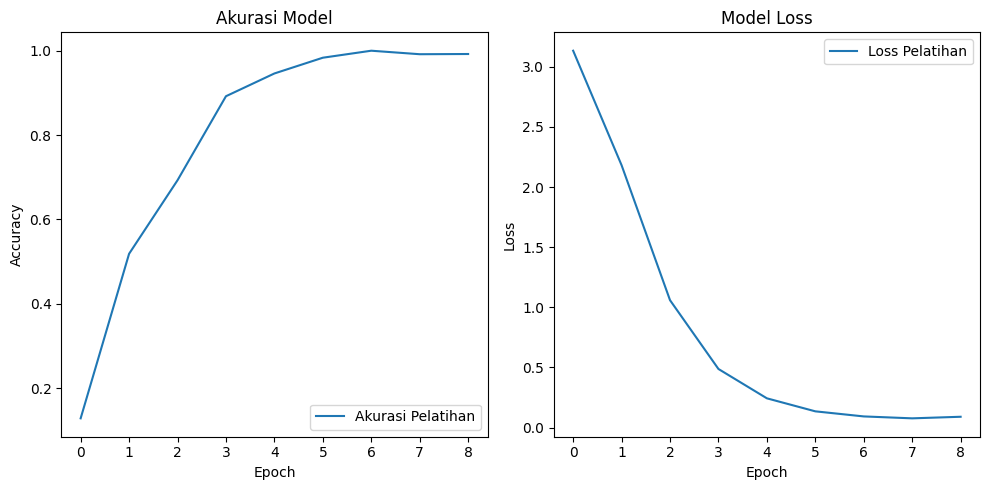

In [30]:
# Plotting accuracy and loss
plt.figure(figsize=(10, 5))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Pelatihan')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Pelatihan')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

Found 71 images belonging to 18 classes.
3/3 [==============================] - 1s 113ms/step


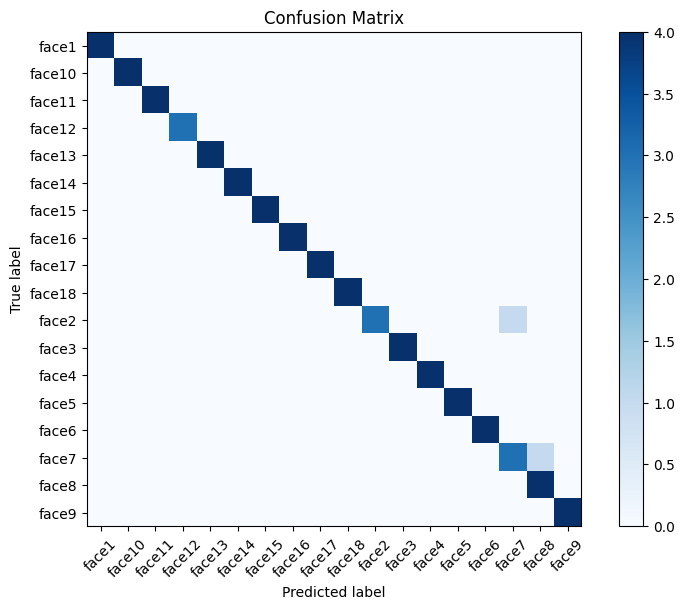

In [32]:
from sklearn.metrics import confusion_matrix
from keras.models import load_model

# Load model
model = load_model('Model_Face_Recognition.h5')

# Data generator untuk test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Penting: jangan acak urutan gambar
)

# Prediksi kelas untuk data test
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Label yang sebenarnya untuk data test
true_classes = test_generator.classes

# Nama kelas
class_labels = list(test_generator.class_indices.keys())

# Membuat confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [33]:
from sklearn.metrics import classification_report

# Membuat classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

# Print classification report
print(report)

              precision    recall  f1-score   support

       face1       1.00      1.00      1.00         4
      face10       1.00      1.00      1.00         4
      face11       1.00      1.00      1.00         4
      face12       1.00      1.00      1.00         3
      face13       1.00      1.00      1.00         4
      face14       1.00      1.00      1.00         4
      face15       1.00      1.00      1.00         4
      face16       1.00      1.00      1.00         4
      face17       1.00      1.00      1.00         4
      face18       1.00      1.00      1.00         4
       face2       1.00      0.75      0.86         4
       face3       1.00      1.00      1.00         4
       face4       1.00      1.00      1.00         4
       face5       1.00      1.00      1.00         4
       face6       1.00      1.00      1.00         4
       face7       0.75      0.75      0.75         4
       face8       0.80      1.00      0.89         4
       face9       1.00    

### Menguji model menggunakan data test

In [35]:
from keras.preprocessing import image
import glob

# Muat model
model = load_model('Model_Face_Recognition.h5')

# Panggil salah satu data
img_path=r"D:/Projek/olivetti_faces.npy/Face Images/Face Images/Final Testing Images/face1/1face10.jpg"
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Lakukan penskalaan seperti yang dilakukan pada data training

# Prediksi kelas
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction)
    
    # Dapatkan label kelas yang sesuai dengan indeks kelas prediksi
class_labels = list(train_generator.class_indices.keys())
predicted_class_label = class_labels[predicted_class_index]
print(predicted_class_label)

1/1 [==============================] - 0s 130ms/step
face1


In [38]:
# Hasil prediksi menggunakan banyak data
## Load semua gambar dari folder data testing
main_ = r"Face Images/Face Images/Final Testing Images"
img_paths = glob.glob(os.path.join(main_,'**','*.jpg'))

print(img_paths[0:5]) # every image will be a PIL object
print('*'*50)

for path in img_paths:
    test_image = image.load_img(path,target_size=(150,150))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image,axis =0)
    result = model.predict(test_image,verbose=0)
    print(f'File: {os.path.basename(path)} - Prediction: ',Result_class[np.argmax(result)])

['Face Images/Face Images/Final Testing Images\\face1\\1face10.jpg', 'Face Images/Face Images/Final Testing Images\\face1\\2face10.jpg', 'Face Images/Face Images/Final Testing Images\\face1\\3face10.jpg', 'Face Images/Face Images/Final Testing Images\\face1\\4face10.jpg', 'Face Images/Face Images/Final Testing Images\\face10\\1face4.jpg']
**************************************************
File: 1face10.jpg - Prediction:  face1
File: 2face10.jpg - Prediction:  face1
File: 3face10.jpg - Prediction:  face1
File: 4face10.jpg - Prediction:  face1
File: 1face4.jpg - Prediction:  face10
File: 2face4.jpg - Prediction:  face10
File: 3face4.jpg - Prediction:  face10
File: 4face4.jpg - Prediction:  face10
File: 1face5.jpg - Prediction:  face11
File: 2face5.jpg - Prediction:  face11
File: 3face5.jpg - Prediction:  face11
File: 4face5.jpg - Prediction:  face11
File: image_0021_Face_17.jpg - Prediction:  face12
File: image_0022_Face_17.jpg - Prediction:  face12
File: image_0023_Face_17.jpg - Predict